# Running HDBSCAN on different combinations of abundances

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table, join, Column
from sklearn.cluster import HDBSCAN
from sklearn.preprocessing import StandardScaler

In [7]:
gaia = Table.read("/Users/chloerenard-robins/Downloads/gaia-eso_v5.fits")

In [9]:
gaia

AL1,AL2,BA2,C1,C2,C3,CA1,CA2,CE2,CO1,CR1,CR2,CU1,C_C2,DECLINATION,ENN_AL1,ENN_AL2,ENN_BA2,ENN_C1,ENN_C2,ENN_C3,ENN_CA1,ENN_CA2,ENN_CE2,ENN_CO1,ENN_CR1,ENN_CR2,ENN_CU1,ENN_C_C2,ENN_EU2,ENN_FEH,ENN_HE1,ENN_LA2,ENN_LOGG,ENN_MG1,ENN_MG2,ENN_MN1,ENN_MO1,ENN_N2,ENN_N3,ENN_NA1,ENN_ND2,ENN_NE1,ENN_NI1,ENN_N_CN,ENN_O1,ENN_O2,ENN_PR2,ENN_S1,ENN_SC1,ENN_SC2,ENN_SI1,ENN_SI2,ENN_SI3,ENN_SI4,ENN_SM2,ENN_SR1,ENN_TEFF,ENN_TI1,ENN_TI2,ENN_V1,ENN_XI,ENN_Y2,ENN_ZN1,ENN_ZR1,ENN_ZR2,EU2,EWC_LI,EW_HA_CHR,EW_HB_CHR,EW_LI,E_AL1,E_AL2,E_BA2,E_C1,E_C2,E_C3,E_CA1,E_CA2,E_CE2,E_CO1,E_CR1,E_CR2,E_CU1,E_C_C2,E_EU2,E_EWC_LI,E_EW_HA_CHR,E_EW_HB_CHR,E_EW_LI,E_FEH,E_FHA_CHR,E_FHB_CHR,E_FWZI,E_GAMMA,E_HA10,E_HE1,E_LA2,E_LI1,E_LOGG,E_MG1,E_MG2,E_MN1,E_MO1,E_N2,E_N3,E_NA1,E_ND2,E_NE1,E_NI1,E_N_CN,E_O1,E_O2,E_PR2,E_S1,E_SC1,E_SC2,E_SI1,E_SI2,E_SI3,E_SI4,E_SM2,E_SR1,E_TEFF,E_TI1,E_TI2,E_V1,E_VEIL,E_VRAD,E_VSINI,E_XI,E_Y2,E_ZN1,E_ZR1,E_ZR2,FEH,FHA_CHR,FHB_CHR,FWZI,GAMMA,GES_FLD,GES_TYPE,HA10,HE1,LA2,LI1,LIM_EWC_LI,LIM_EW_LI,LIM_LI1,LIM_VSINI,LOGG,MEM3D,MG1,MG2,MN1,MO1,N2,N3,NA1,ND2,NE1,NF_VRAD_FLAG,NI1,NL_AL1,NL_AL2,NL_BA2,NL_C1,NL_C2,NL_C3,NL_CA1,NL_CA2,NL_CE2,NL_CO1,NL_CR1,NL_CR2,NL_CU1,NL_C_C2,NL_EU2,NL_HE1,NL_LA2,NL_MG1,NL_MG2,NL_MN1,NL_MO1,NL_N2,NL_N3,NL_NA1,NL_ND2,NL_NE1,NL_NI1,NL_N_CN,NL_O1,NL_O2,NL_PR2,NL_S1,NL_SC1,NL_SC2,NL_SI1,NL_SI2,NL_SI3,NL_SI4,NL_SM2,NL_SR1,NL_TI1,NL_TI2,NL_V1,NL_Y2,NL_ZN1,NL_ZR1,NL_ZR2,NNE_FEH,NNE_LOGG,NNE_TEFF,NNE_XI,NN_AL1,NN_AL2,NN_BA2,NN_C1,NN_C2,NN_C3,NN_CA1,NN_CA2,NN_CE2,NN_CO1,NN_CR1,NN_CR2,NN_CU1,NN_C_C2,NN_EU2,NN_FEH,NN_HE1,NN_LA2,NN_LOGG,NN_MG1,NN_MG2,NN_MN1,NN_MO1,NN_N2,NN_N3,NN_NA1,NN_ND2,NN_NE1,NN_NI1,NN_N_CN,NN_O1,NN_O2,NN_PR2,NN_S1,NN_SC1,NN_SC2,NN_SI1,NN_SI2,NN_SI3,NN_SI4,NN_SM2,NN_SR1,NN_TEFF,NN_TI1,NN_TI2,NN_V1,NN_XI,NN_Y2,NN_ZN1,NN_ZR1,NN_ZR2,N_CN,O1,O2,OBJECT,ORIGIN_AL1,ORIGIN_AL2,ORIGIN_BA2,ORIGIN_C1,ORIGIN_C2,ORIGIN_C3,ORIGIN_CA1,ORIGIN_CA2,ORIGIN_CE2,ORIGIN_CO1,ORIGIN_CR1,ORIGIN_CR2,ORIGIN_CU1,ORIGIN_C_C2,ORIGIN_EU2,ORIGIN_HE1,ORIGIN_LA2,ORIGIN_MG1,ORIGIN_MG2,ORIGIN_MN1,ORIGIN_MO1,ORIGIN_N2,ORIGIN_N3,ORIGIN_NA1,ORIGIN_ND2,ORIGIN_NE1,ORIGIN_NI1,ORIGIN_N_CN,ORIGIN_O1,ORIGIN_O2,ORIGIN_PR2,ORIGIN_S1,ORIGIN_SC1,ORIGIN_SC2,ORIGIN_SI1,ORIGIN_SI2,ORIGIN_SI3,ORIGIN_SI4,ORIGIN_SM2,ORIGIN_SR1,ORIGIN_TI1,ORIGIN_TI2,ORIGIN_V1,ORIGIN_VRAD,ORIGIN_Y2,ORIGIN_ZN1,ORIGIN_ZR1,ORIGIN_ZR2,PECULI,PR2,RA,RAVAIL_SETUP,REC_SETUP,REC_WG,S1,SC1,SC2,SETUP,SFLAGS,SI1,SI2,SI3,SI4,SM2,SNR,SR1,TECH,TEFF,TI1,TI2,V1,VEIL,VRAD,VRAD_FLAG,VRAD_OFFSET,VSINI,XI,Y2,ZN1,ZR1,ZR2
dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,deg,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,K,dex,dex,dex,km / s,dex,dex,dex,dex,dex,Angstrom,Angstrom,Angstrom,Angstrom,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,Angstrom,Angstrom,Angstrom,Angstrom,dex,erg / (s cm2),erg / (s cm2),Angstrom,,km / s,dex,dex,dex,log(cm/s**2),dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,K,dex,dex,dex,,km / s,km / s,km / s,dex,dex,dex,dex,dex,erg / (s cm2),erg / (s cm2),Angstrom,,,,km / s,dex,dex,dex,,,,,log(cm/s**2),,dex,dex,dex,dex,dex,dex,dex,dex,dex,,dex,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,dex,dex,dex,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,dex,deg,,,,dex,dex,dex,,,dex,dex,dex,dex,dex,,dex,,K,dex,dex,dex,,km / s,,km / s,km / s,km / s,dex,dex,dex,dex
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,

In [21]:
good = np.where((gaia['AL1'] > -99) & (gaia['MN1'] > -99) & (gaia['C1'] > -99) & (gaia['MG1'] > -99)
       & (gaia['SNR'] > 100) & (gaia['FEH'] > -99))
# select the lines from the data table where certain concentrations are larger than -99
print(good)

(array([     0,      1,      2, ..., 113849, 113850, 113851]),)


#### joining the spectroscopic and dynamical data

In [189]:
# joins the HDBSCAN output table and the dynamics table by identifying the cluster by its Apogee ID
spectroscopy_dynamics_joined = join (apogee[good],apogee_dynamics, keys='APOGEE_ID', join_type='inner') 

In [191]:
spectroscopy_dynamics_joined

FILE,APOGEE_ID,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,TARG_PMRA,TARG_PMDEC,TARG_PM_SRC,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NVISITS,SNR,SNREV,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CHI2,RV_CCFWHM,RV_AUTOFWHM,RV_FLAG,N_COMPONENTS,MEANFIB,SIGFIB,MIN_H,MAX_H,MIN_JK,MAX_JK,GAIAEDR3_SOURCE_ID,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PHOT_G_MEAN_MAG,GAIAEDR3_PHOT_BP_MEAN_MAG,GAIAEDR3_PHOT_RP_MEAN_MAG,GAIAEDR3_DR2_RADIAL_VELOCITY,GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR,GAIAEDR3_R_MED_GEO,GAIAEDR3_R_LO_GEO,GAIAEDR3_R_HI_GEO,GAIAEDR3_R_MED_PHOTOGEO,GAIAEDR3_R_LO_PHOTOGEO,GAIAEDR3_R_HI_PHOTOGEO,ASPCAP_GRID,FPARAM_GRID,CHI2_GRID,FPARAM,FPARAM_COV,ASPCAP_CHI2,PARAM,PARAM_COV,PARAMFLAG,ASPCAPFLAG,ASPCAPFLAGS,FRAC_BADPIX,FRAC_LOWSNR,FRAC_SIGSKY,FELEM,FELEM_ERR,X_H,X_H_ERR,X_M,X_M_ERR,ELEM_CHI2,ELEMFRAC,ELEMFLAG,EXTRATARG,MEMBERFLAG,MEMBER,X_H_SPEC,X_M_SPEC,TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,VMICRO,VMACRO,VSINI,TEFF_SPEC,LOGG_SPEC,C_FE,C_FE_SPEC,C_FE_ERR,C_FE_FLAG,CI_FE,CI_FE_SPEC,CI_FE_ERR,CI_FE_FLAG,N_FE,N_FE_SPEC,N_FE_ERR,N_FE_FLAG,O_FE,O_FE_SPEC,O_FE_ERR,O_FE_FLAG,NA_FE,NA_FE_SPEC,NA_FE_ERR,NA_FE_FLAG,MG_FE,MG_FE_SPEC,MG_FE_ERR,MG_FE_FLAG,AL_FE,AL_FE_SPEC,AL_FE_ERR,AL_FE_FLAG,SI_FE,SI_FE_SPEC,SI_FE_ERR,SI_FE_FLAG,P_FE,P_FE_SPEC,P_FE_ERR,P_FE_FLAG,S_FE,S_FE_SPEC,S_FE_ERR,S_FE_FLAG,K_FE,K_FE_SPEC,K_FE_ERR,K_FE_FLAG,CA_FE,CA_FE_SPEC,CA_FE_ERR,CA_FE_FLAG,TI_FE,TI_FE_SPEC,TI_FE_ERR,TI_FE_FLAG,TIII_FE,TIII_FE_SPEC,TIII_FE_ERR,TIII_FE_FLAG,V_FE,V_FE_SPEC,V_FE_ERR,V_FE_FLAG,CR_FE,CR_FE_SPEC,CR_FE_ERR,CR_FE_FLAG,MN_FE,MN_FE_SPEC,MN_FE_ERR,MN_FE_FLAG,FE_H,FE_H_SPEC,FE_H_ERR,FE_H_FLAG,CO_FE,CO_FE_SPEC,CO_FE_ERR,CO_FE_FLAG,NI_FE,NI_FE_SPEC,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,YB_FE,YB_FE_SPEC,YB_FE_ERR,YB_FE_FLAG,VISIT_PK,E,L,R_guide,actions,angles,ecc,freqs,r_apo,r_per,vxyz,xyz,z_max
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,km2 / s2,km kpc / s,,km kpc / s,rad,,rad / Gyr,kpc,kpc,km / s,kpc,kpc
bytes64,bytes30,bytes58,bytes71,bytes77,bytes6,int32,bytes20,bytes30,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,bytes16,float32,bytes32,float32,float32,int32,int32,int32,int32,int32,int32,bytes132,bytes32,bytes32,int32,float32,float32,int64,bytes132,int64,bytes132,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,"float32[21,9]",float32[21],float32[9],"float32[9,9]",float32,float32[9],"float32[9,9]",int64[9],int64,bytes256,float32,float32,float32,float32[27],float64[27],float32[27],float32[27],float32[27],float32[27],float32[27],float32[27],int64[27],int32,int64,bytes10,float32[27],float32[27],float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float3

In [199]:
# turns the data within the action and L columns into arrays
actions_arr = np.array(spectroscopy_dynamics_joined['actions'].tolist())
L_arr = np.array(spectroscopy_dynamics_joined['L'].tolist())

# creates seperate columns for each of the actions
action_names = ['J_R', 'L_z', 'J_z'] 
for i, name in enumerate(action_names): # iterates through each value in the action column, associating it to the right column by its index
    col = Column(actions_arr[:, i], name=name)
    if name in spectroscopy_dynamics_joined.colnames: # accounts for the case where the column with the given name already exists
        spectroscopy_dynamics_joined.replace_column(name, col)
    else:
        spectroscopy_dynamics_joined.add_column(col)

# creates seperate columns for each of the L values
L_names = ['L_x', 'L_y', 'L_z']
for i, name in enumerate(L_names):
    col = Column(L_arr[:, i], name=name)
    if name in spectroscopy_dynamics_joined.colnames:
        spectroscopy_dynamics_joined.replace_column(name, col)
    else:
        spectroscopy_dynamics_joined.add_column(col)

# removes original columns
spectroscopy_dynamics_joined.remove_column('actions')
spectroscopy_dynamics_joined.remove_column('L')

spectroscopy_dynamics_joined

FILE,APOGEE_ID,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,TARG_PMRA,TARG_PMDEC,TARG_PM_SRC,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NVISITS,SNR,SNREV,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CHI2,RV_CCFWHM,RV_AUTOFWHM,RV_FLAG,N_COMPONENTS,MEANFIB,SIGFIB,MIN_H,MAX_H,MIN_JK,MAX_JK,GAIAEDR3_SOURCE_ID,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PHOT_G_MEAN_MAG,GAIAEDR3_PHOT_BP_MEAN_MAG,GAIAEDR3_PHOT_RP_MEAN_MAG,GAIAEDR3_DR2_RADIAL_VELOCITY,GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR,GAIAEDR3_R_MED_GEO,GAIAEDR3_R_LO_GEO,GAIAEDR3_R_HI_GEO,GAIAEDR3_R_MED_PHOTOGEO,GAIAEDR3_R_LO_PHOTOGEO,GAIAEDR3_R_HI_PHOTOGEO,ASPCAP_GRID,FPARAM_GRID,CHI2_GRID,FPARAM,FPARAM_COV,ASPCAP_CHI2,PARAM,PARAM_COV,PARAMFLAG,ASPCAPFLAG,ASPCAPFLAGS,FRAC_BADPIX,FRAC_LOWSNR,FRAC_SIGSKY,FELEM,FELEM_ERR,X_H,X_H_ERR,X_M,X_M_ERR,ELEM_CHI2,ELEMFRAC,ELEMFLAG,EXTRATARG,MEMBERFLAG,MEMBER,X_H_SPEC,X_M_SPEC,TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,VMICRO,VMACRO,VSINI,TEFF_SPEC,LOGG_SPEC,C_FE,C_FE_SPEC,C_FE_ERR,C_FE_FLAG,CI_FE,CI_FE_SPEC,CI_FE_ERR,CI_FE_FLAG,N_FE,N_FE_SPEC,N_FE_ERR,N_FE_FLAG,O_FE,O_FE_SPEC,O_FE_ERR,O_FE_FLAG,NA_FE,NA_FE_SPEC,NA_FE_ERR,NA_FE_FLAG,MG_FE,MG_FE_SPEC,MG_FE_ERR,MG_FE_FLAG,AL_FE,AL_FE_SPEC,AL_FE_ERR,AL_FE_FLAG,SI_FE,SI_FE_SPEC,SI_FE_ERR,SI_FE_FLAG,P_FE,P_FE_SPEC,P_FE_ERR,P_FE_FLAG,S_FE,S_FE_SPEC,S_FE_ERR,S_FE_FLAG,K_FE,K_FE_SPEC,K_FE_ERR,K_FE_FLAG,CA_FE,CA_FE_SPEC,CA_FE_ERR,CA_FE_FLAG,TI_FE,TI_FE_SPEC,TI_FE_ERR,TI_FE_FLAG,TIII_FE,TIII_FE_SPEC,TIII_FE_ERR,TIII_FE_FLAG,V_FE,V_FE_SPEC,V_FE_ERR,V_FE_FLAG,CR_FE,CR_FE_SPEC,CR_FE_ERR,CR_FE_FLAG,MN_FE,MN_FE_SPEC,MN_FE_ERR,MN_FE_FLAG,FE_H,FE_H_SPEC,FE_H_ERR,FE_H_FLAG,CO_FE,CO_FE_SPEC,CO_FE_ERR,CO_FE_FLAG,NI_FE,NI_FE_SPEC,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,YB_FE,YB_FE_SPEC,YB_FE_ERR,YB_FE_FLAG,VISIT_PK,E,R_guide,angles,ecc,freqs,r_apo,r_per,vxyz,xyz,z_max,J_R,L_z,J_z,L_x,L_y
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,km2 / s2,,rad,,rad / Gyr,kpc,kpc,km / s,kpc,kpc,,,,,
bytes64,bytes30,bytes58,bytes71,bytes77,bytes6,int32,bytes20,bytes30,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,bytes16,float32,bytes32,float32,float32,int32,int32,int32,int32,int32,int32,bytes132,bytes32,bytes32,int32,float32,float32,int64,bytes132,int64,bytes132,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,"float32[21,9]",float32[21],float32[9],"float32[9,9]",float32,float32[9],"float32[9,9]",int64[9],int64,bytes256,float32,float32,float32,float32[27],float64[27],float32[27],float32[27],float32[27],float32[27],float32[27],float32[27],int64[27],int32,int64,bytes10,float32[27],float32[27],float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32

#### running HDBSCAN and dynamical spread analysis on different combinations of abundances

In [27]:
gaia_table_chunk_going_into_hdbscan = gaia[good]['FEH','AL1','MN1','C1','MG1', 'BA2', 'CE2']
abund_cols = ['FEH','AL1','MN1','C1','MG1', 'BA2', 'CE2'] # creates a list of the columns of abundances that will be used
label_col  = 'HDBSCAN_Cluster' # creates a column for the cluster group 
df = gaia_table_chunk_going_into_hdbscan.to_pandas().astype('float64')  # transforms table of columns that will run through HDBSCAN into a DataFrame

In [29]:
# creates a list of all of the different possible combinations of the seven abundances used
combos = (
    list(itertools.combinations(abund_cols, 2)) +  # all 2‑D combinations
    list(itertools.combinations(abund_cols, 3)) +  # all 3‑D combinations
    list(itertools.combinations(abund_cols, 4)) +  # all 4‑D combinations
    list(itertools.combinations(abund_cols, 5)) +  # all 5‑D combinations
    list(itertools.combinations(abund_cols, 6)) +  # all 6‑D combinations
    list(itertools.combinations(abund_cols, 7))    # all 7‑D combinations
)

In [31]:
mcs = 3 #this is what the other paper said
maxcs = 1222 # arbitrary
cse = 0.02

In [41]:
clusterers = {}  # creates a dictionary to hold each fitted HDBSCAN model 
cluster_labels_dict = {}  # creates a dictrionary to hold all new columns
#spread_cols = ['E', 'R_guide', 'ecc', 'z_max', 'J_R', 'J_z', 'L_z', 'L_x', 'L_y'] # creates a list of the columns that will be used to calculate spread
#spread_results = {} # creates a dictionary to hold the calculated results of the spreads

df_abund = gaia_table_chunk_going_into_hdbscan.to_pandas().astype('float64') # abundance DataFrame (used for clustering)

# dynamical DataFrame (used for spread analysis)
#df_dyn = pd.DataFrame(
    #{col: np.asarray(gaia[good][col], dtype='float64') # turns each column into a numpy array and assigns each array to its corresponding key
     #for col in spread_cols}, # loops through each column in spread_cols  
    #index=np.arange(len(gaia[good])) # ensures that the DataFrame has the same length as the astropy table
#)
#df_dyn['CNAME'] = gaia[good]['CNAME'] # adds a column to the DataaFrame for apogee id


for combo in combos: # loops over each tuple of abundances
    tag = '|'.join(combo) # joins the different abundances into a name with abundances seperated by |
    features = df_abund[list(combo)].to_numpy() # pulls only the relevent columns from df and turns it into a numpy array
    hdb = HDBSCAN(min_cluster_size=mcs, cluster_selection_epsilon = cse, max_cluster_size= maxcs) # configures a new HDBSCAN instance
    hdb.fit(features) # runs HDBSCAN
    labels = hdb.labels_.astype(int) 
    clusterers[tag] = hdb # saves the fitted model into the clusterers dictionary
    cluster_labels_dict[f'cluster_{tag}'] = labels # stores labels in the column dictionary
    #dyn_tmp = df_dyn.copy() # compute average cluster size
    #dyn_tmp['HDBSCAN_Cluster'] = labels # Merge cluster labels with dynamical data
    #dyn_good = dyn_tmp[~dyn_tmp['HDBSCAN_Cluster'].isin([-1, -3])] # remove noise and outliers
    #spread = dyn_good.groupby('HDBSCAN_Cluster')[spread_cols].std() # compute spread within each cluster
    #spread_results[tag] = spread.mean()  # average spread per dynamical variable
cluster_df = pd.DataFrame(cluster_labels_dict, index=df.index) # creates a dataframe with every key in cluster_labels_dict as a column and the same index as df
df = pd.concat([df, cluster_df], axis=1) # attaches all new cluster columns to the main DataFrame
#spread_summary = pd.DataFrame(spread_results).T  # rows = tags, cols = variables
#spread_summary.reset_index(inplace=True)
#spread_summary.rename(columns={'index': 'combo_tag'}, inplace=True)
#spread_table = Table.from_pandas(spread_summary)

In [43]:
cluster_counts = {} # creates an empty dictionary that will map combo tag to the number of clusters

for tag in clusterers.keys(): # iterates over every abundance combo
    col = f'cluster_{tag}' # builds the dataframe column name
    unique_labels = pd.unique(df[col].values.ravel()) # grabs all the distinct label values that represent seperate clusters in that column 
    n_clusters = len(unique_labels[unique_labels >= 0])  # ignores all the values that are negative (-1 is noise)
    cluster_counts[tag] = n_clusters # saves the count of clusters to a dictionary

print("Clusters found per combo:")
for tag, n in cluster_counts.items(): # iterates over the dictionary
    print(f"{tag:<30}  {n:3d}") # prints the tags is a readable format (left aligns the tag in a 30 character field and shows the number of clusters as a three digit integer)

Clusters found per combo:
FEH|AL1                          58
FEH|MN1                          48
FEH|C1                           77
FEH|MG1                          48
FEH|BA2                          56
FEH|CE2                          43
AL1|MN1                          80
AL1|C1                           64
AL1|MG1                          37
AL1|BA2                          79
AL1|CE2                          57
MN1|C1                          102
MN1|MG1                          72
MN1|BA2                          73
MN1|CE2                          50
C1|MG1                           64
C1|BA2                           97
C1|CE2                           80
MG1|BA2                          59
MG1|CE2                          44
BA2|CE2                          40
FEH|AL1|MN1                     158
FEH|AL1|C1                      173
FEH|AL1|MG1                     123
FEH|AL1|BA2                     147
FEH|AL1|CE2                     114
FEH|MN1|C1                      167
FE

In [45]:
tags    = list(cluster_counts.keys())          # abundance‑combo strings
n_clust = [cluster_counts[t] for t in tags]    # corresponding counts

results_tbl = Table(
    [tags, n_clust],
    names=('combo_tag', 'n_clusters')
)

In [51]:
results_tbl#.pprint(max_lines=-1) # makes all lines visible

combo_tag,n_clusters
str26,int64
FEH|AL1,58
FEH|MN1,48
FEH|C1,77
FEH|MG1,48
FEH|BA2,56
FEH|CE2,43
AL1|MN1,80
AL1|C1,64
AL1|MG1,37


In [327]:
average_cluster_sizes = {}  # combo tag → average size
outlier_counts = {}

for tag, hdb in clusterers.items():
    labels = hdb.labels_  # get cluster labels for this combo
    n_outlier = sum(labels == -1) # counts number of outliers 
    outlier_counts[tag] = n_outlier # stores the outlier count for a particular combination of abundances in a dictionary
    labels_cleaned = labels[labels != -1] # filters out noise 
    cluster_count = pd.Series(labels_cleaned).value_counts() # counts the number of stars in each cluster
    avg_size = cluster_count.mean() # computes the average number of stars in each cluster
    average_cluster_sizes[tag] = avg_size # stores the average cluster size for a particular combination of abundances in a dictionary

# convert to a table
combo_tags = list(average_cluster_sizes.keys())
avg_sizes = list(average_cluster_sizes.values())
outlier_number = list(outlier_counts.values())

# creates pandas DataFrame
avg_size_outlier_df = pd.DataFrame({
    'Abundance_Combination': combo_tags,
    'Average_Cluster_Size': avg_sizes,
    'Number_Outliers': outlier_number
})
# converts to Astropy Table
avg_size_outlier_table = Table.from_pandas(avg_size_outlier_df)

In [329]:
avg_size_outlier_table.pprint(max_lines=-1) # makes all lines visible

        Abundance_Combination          Average_Cluster_Size Number_Outliers
-------------------------------------- -------------------- ---------------
                            FE_H|MG_FE               6786.5              51
                             FE_H|N_FE    615.7272727272727              78
                             FE_H|C_FE    796.3529411764706              86
                            FE_H|AL_FE               1353.7              87
                            FE_H|MN_FE               6779.0              66
                            FE_H|CE_FE                213.0             205
                            MG_FE|N_FE                903.8              67
                            MG_FE|C_FE               1233.0              61
                           MG_FE|AL_FE               1696.0              56
                           MG_FE|MN_FE               4535.0              19
                           MG_FE|CE_FE    328.7317073170732             146
            

In [331]:
avg_size_outlier_table

Abundance_Combination,Average_Cluster_Size,Number_Outliers
str38,float64,int64
FE_H|MG_FE,6786.5,51
FE_H|N_FE,615.7272727272727,78
FE_H|C_FE,796.3529411764706,86
FE_H|AL_FE,1353.7,87
FE_H|MN_FE,6779.0,66
FE_H|CE_FE,213.0,205
MG_FE|N_FE,903.8,67
MG_FE|C_FE,1233.0,61
MG_FE|AL_FE,1696.0,56


In [333]:
spread_table # prints the spread data as an astropy table

combo_tag,E,R_guide,ecc,z_max,J_R,J_z,L_z,L_x,L_y
str38,float64,float64,float64,float64,float64,float64,float64,float64,float64
FE_H|MG_FE,5767.720476432563,1.2787439430950769,0.07102145202257872,0.4127294526334384,38.04842638538085,15.09507107607359,270.2046602551089,13.76624162022542,13.811099193253556
FE_H|N_FE,6375.887086389153,1.4186765958657819,0.08157001879988492,0.3486657803376063,49.88105291594973,11.135282651157418,294.89741538269925,10.260526400182771,8.843002055385638
FE_H|C_FE,7110.96628706837,1.5978609580374519,0.07404348140968817,0.45258617108487165,54.90602517451774,16.267092086376866,329.40843811910673,12.080658166733397,12.190733675301695
FE_H|AL_FE,5861.713919576598,1.36947899230754,0.1061020011004298,0.32129827379128356,59.700485380843155,12.963192702311309,298.3976102305738,13.901283126200184,13.001072622970128
FE_H|MN_FE,6483.185755403184,1.3632687413553342,0.0787298159275632,0.4486949178718579,42.455724221242846,14.734761886617207,285.2969181218773,13.21435520873982,11.037218000489144
FE_H|CE_FE,7470.064790439575,1.6874145091607473,0.09034482255202582,0.5663153588373727,50.26102451985976,20.370810658356277,353.3476373016564,18.641962329651076,18.553782975209785
MG_FE|N_FE,8436.309686069335,1.8204504322838955,0.09127993474827956,0.5695723351844616,71.50550880606822,23.097351900901923,378.0283776017534,24.06393179214111,22.468766598121256
MG_FE|C_FE,6605.77046784304,1.5213542461938152,0.0892381366127284,0.5961409371168466,74.02625233648726,22.561992695932783,310.88375953430074,12.105180294296941,21.09758184599642
MG_FE|AL_FE,6115.508888567066,1.397846889179445,0.08298090461364424,0.46202523484417213,40.117946980806586,14.790114352032933,298.19005577839425,14.03874720988377,13.613632821109794


#### plot of results

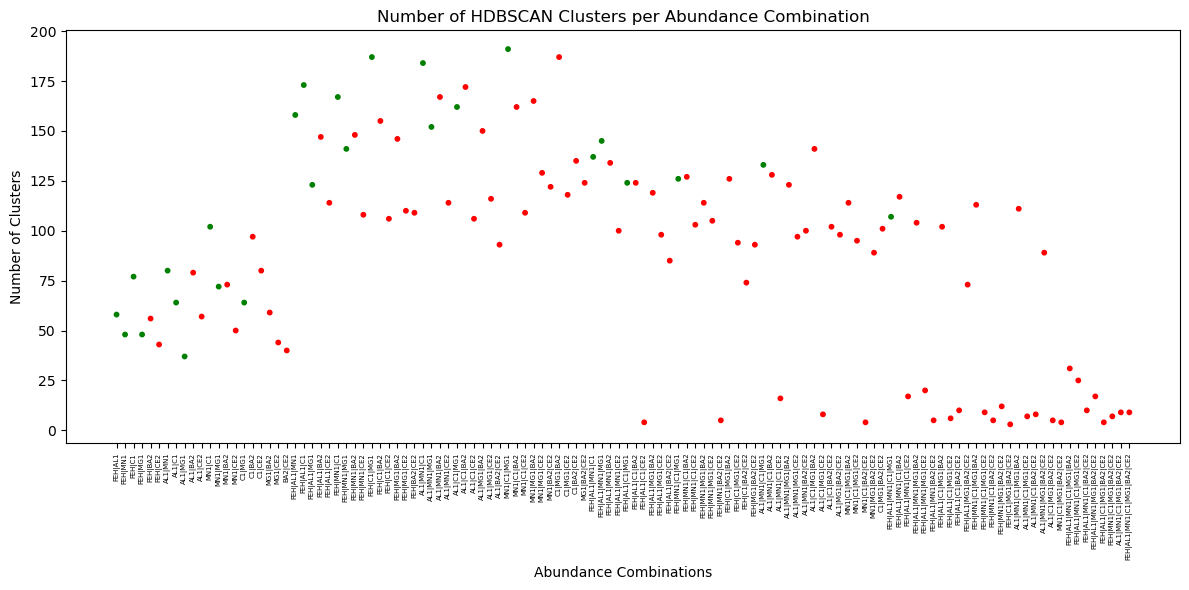

In [49]:
import matplotlib.pyplot as plt

x_labels = list(cluster_counts.keys()) # assigns the names of combinations of abundances as the x-axis
y_values = list(cluster_counts.values()) # assigns the number of clusters as the y-axis

point_colors = ['red' if 'CE2' in tag or 'BA2' in tag else 'green' for tag in x_labels] # color list so the dot is red if 'CE2' or 'BA2' in tag, else green

# creates the scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(x_labels, y_values, color=point_colors, s=10)

plt.xticks(rotation=90, fontsize=5) # improves readability of long x-axis labels by rotating 90 degrees and shrinking font size
plt.xlabel("Abundance Combinations")
plt.ylabel("Number of Clusters")
plt.title("Number of HDBSCAN Clusters per Abundance Combination")
plt.tight_layout()

plt.show()


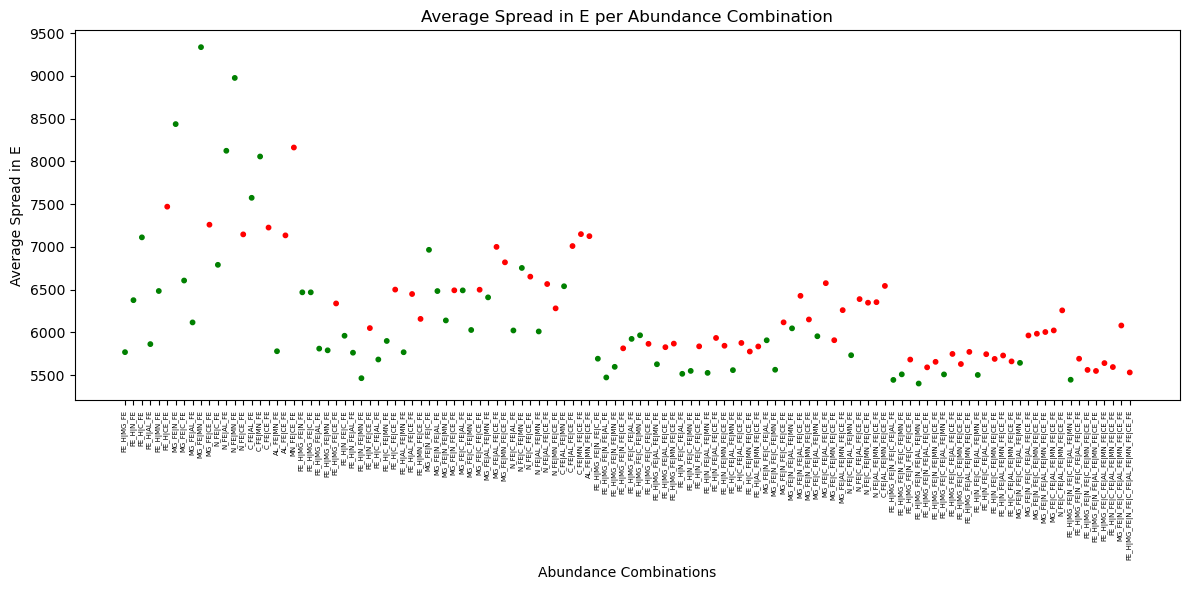

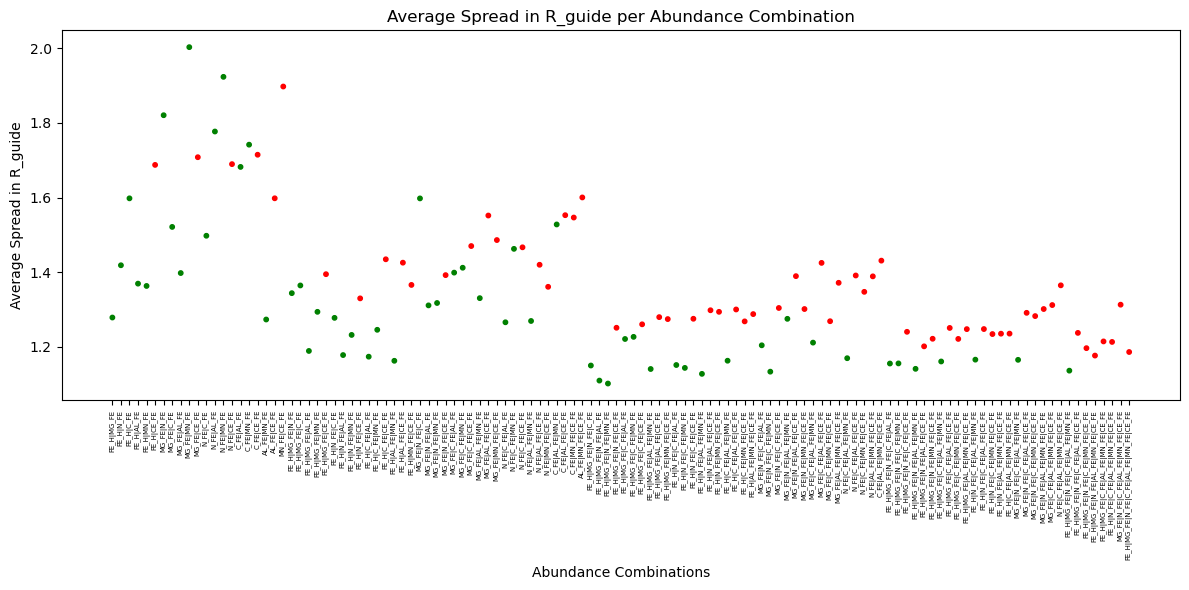

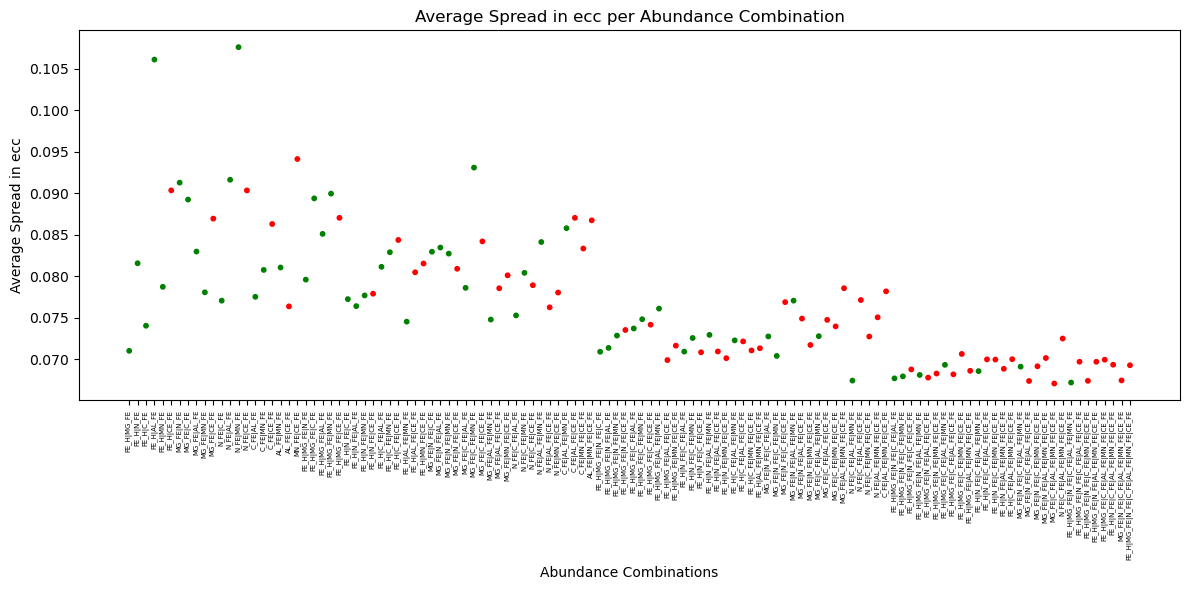

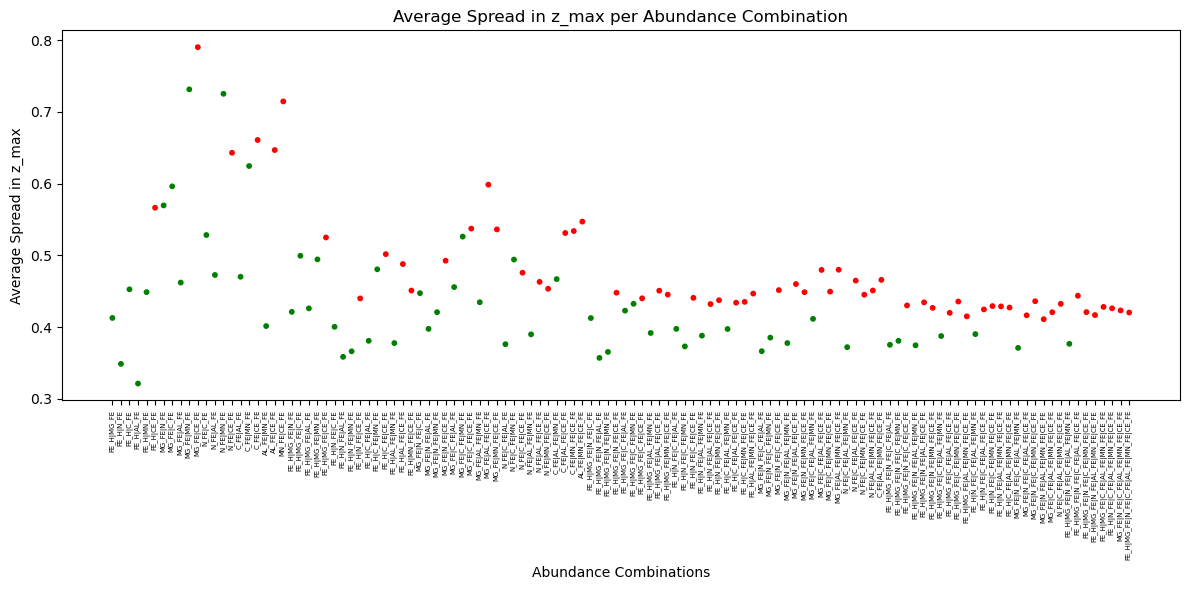

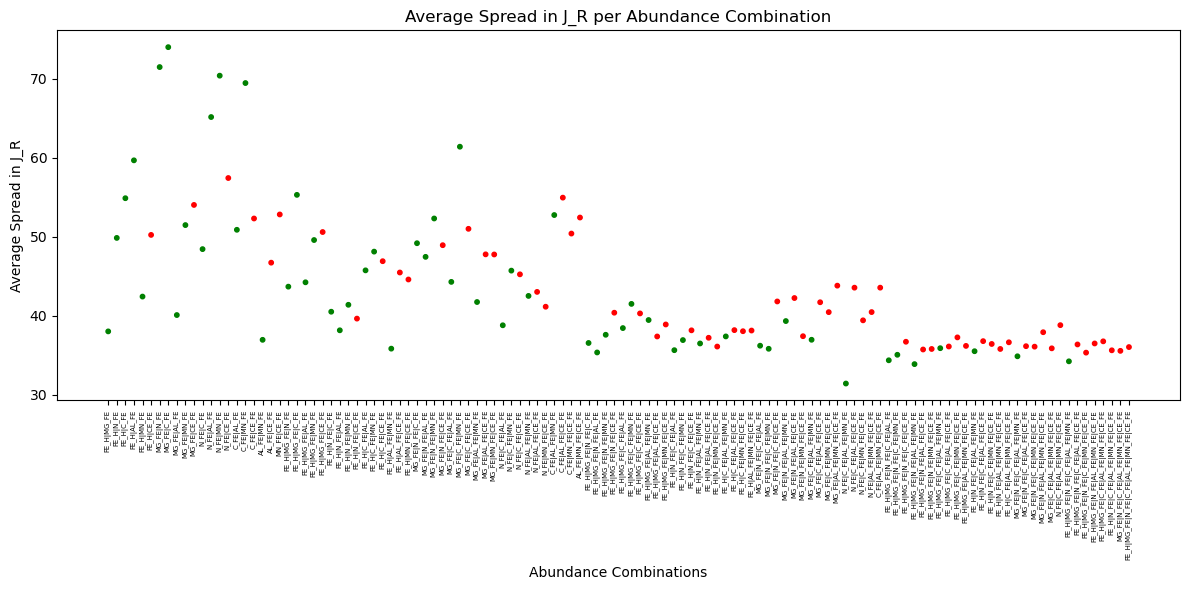

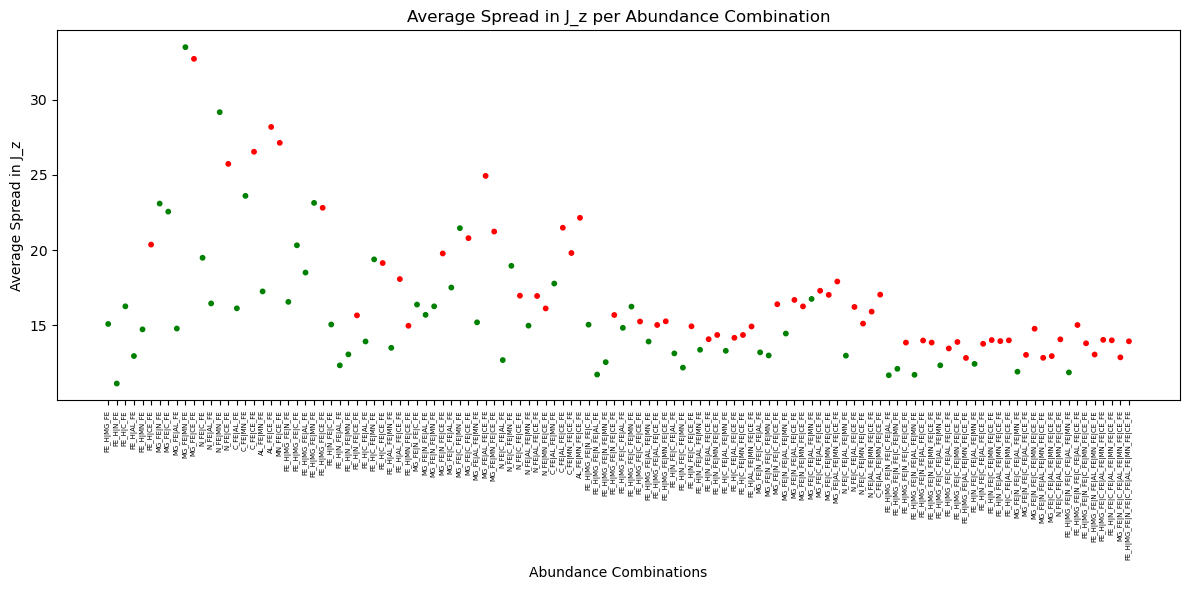

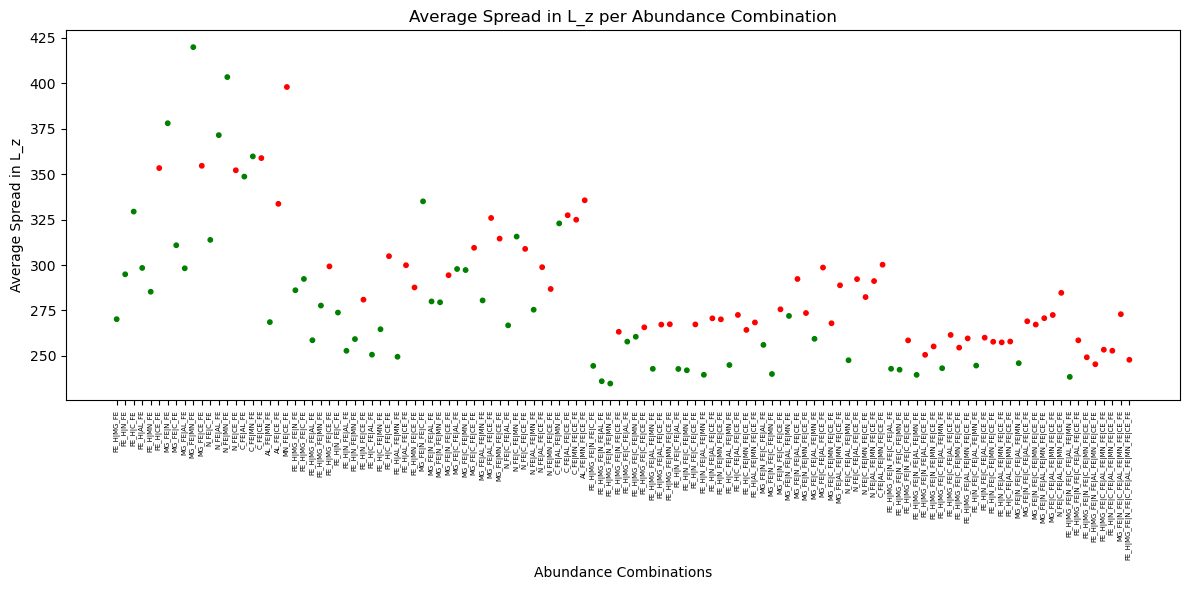

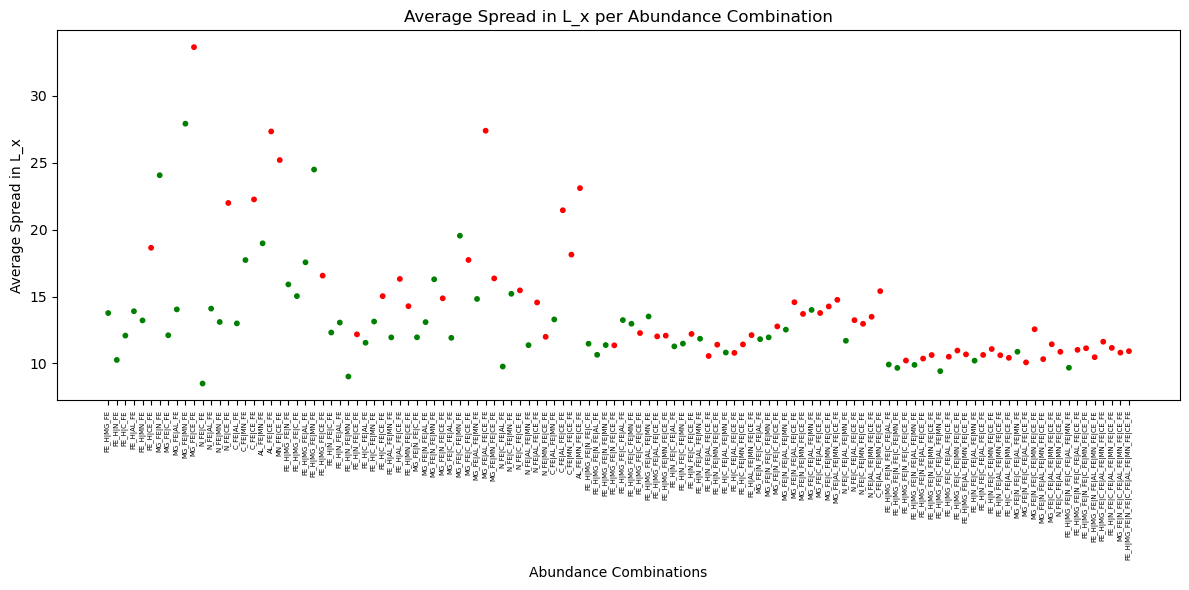

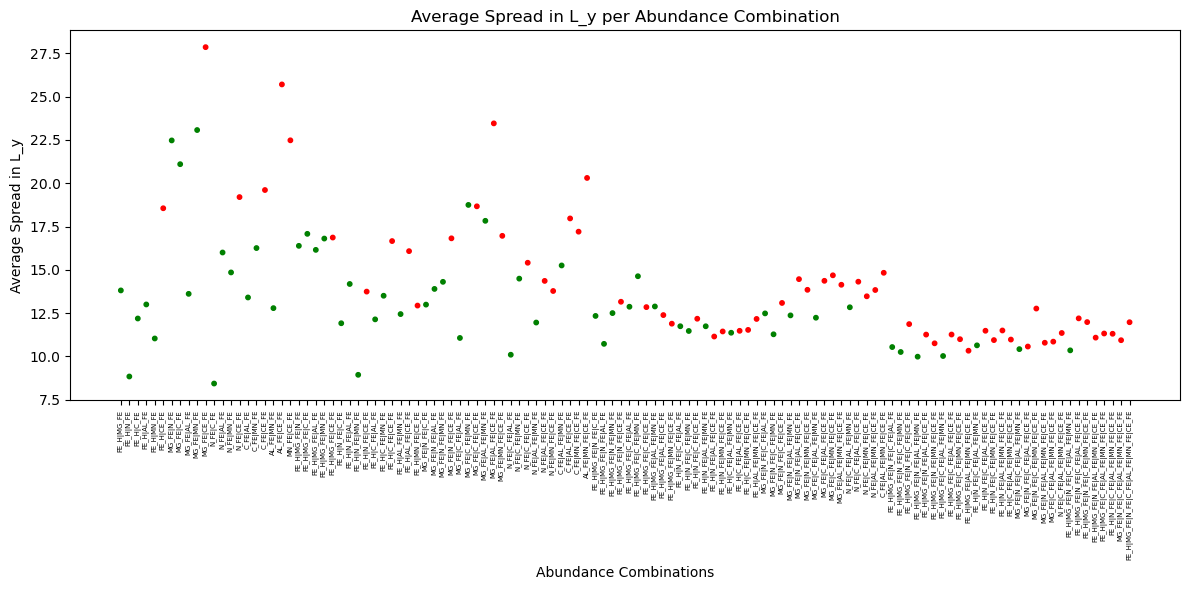

In [338]:
for col in spread_summary.columns:
    if col == 'combo_tag':  # avoid printing a plot with combo tag vs. combo tag
        continue  # skip this column
    plt.figure(figsize=(12, 6))
    x_labels = spread_summary['combo_tag'].tolist() # adds each combination of abundances to a list that becomes the x values
    y_values = spread_summary[col].values # extracts the values from the specified column and assigns them as the y value

    point_colors = ['red' if 'CE_FE' in str(tag) else 'green' for tag in x_labels] # makes the points corresponding to abundance combos with Ce show up in red and all others show up in green
    
    plt.scatter(x_labels, y_values, color=point_colors, s=10)
    plt.xticks(rotation=90, fontsize=5)
    plt.xlabel("Abundance Combinations")
    plt.ylabel(f"Average Spread in {col}") # flexible name that changes for each property
    plt.title(f"Average Spread in {col} per Abundance Combination")
    plt.tight_layout()
    plt.show()

In [294]:
print(repr(spread_summary.columns.tolist()))

['combo_tag', 'E', 'R_guide', 'ecc', 'z_max', 'J_R', 'J_z', 'L_z', 'L_x', 'L_y']
